In [2]:
%matplotlib inline

In [3]:
#for wider display
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:70% !important; }</style>"))

In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pandas.plotting import scatter_matrix
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import scale
from sklearn.preprocessing import Imputer 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


In [5]:
#matplotlib style
plt.style.use('fivethirtyeight')

# Data Selection and Preprocessing	
## Data handling and derived variables
Data was import as dataframe and date was used as index.'weekday', 'holiday' and 'temp' were dropped for 'workingday' and 'atemp' contained the same or better infomation.
Because some holidays eg. Christmas has longer effect, days around were also changed as holiday. 'disaster' column was add to indicate extreme weather condition such like storm, tornado and hurrican.
To reduce the effect of nature outlier, columns of 'casual', 'registered' and 'cnt' were transformed into logarithm as 'casual_log' and 'registered_log'. 'casual_log' and 'registered_log' were used as model target variable and were modeled separately. The predicted values were transformed back to normal and added up as predicted 'cnt'.

In [6]:
#read data from day.csv with date as index and drop extra columns
df = pd.read_csv('day.csv',index_col='dteday', parse_dates=True).drop(['holiday','temp'], axis=1)
df.index.name = 'date'

In [7]:
#derive variables 
#df['day'] = df.index.day #day of month
#df['delta_days'] = df.index - pd.to_datetime('2011-1-1')
#df['delta_days'] = df['delta_days'].dt.days #turn timedelta object to int 
#use instant as delta_days
#df['date'] = df.index.date
#df['yr'] = df.index.year
#df['season'] = df.index.quarter
#df['mnth'] = df.index.month
#df['weekday'] = df.index.dayofweek
df['weekofyear'] = df.index.weekofyear
#df['dayofyear'] = df.index.dayofyear

In [8]:
# tax day
df.loc['2011-4-15', "workingday"] = 1
df.loc['2012-4-16', "workingday"] = 1
# thanksgiving friday
df.loc['2011-11-25', "workingday"] = 0
df.loc['2012-11-23', "workingday"] = 0

# Christmas and newyear
df.loc['2011-12-24':'2011-12-31', "workingday"] = 0
df.loc['2012-12-24':'2011-12-31', "workingday"] = 0
df.loc['2011-1-1':'2011-1-3', "workingday"] = 0
df.loc['2012-1-1':'2011-1-3', "workingday"] = 0

df['disaster'] = 0

#storms
df.loc['2012-5-21', "workingday"] = 0
df.loc['2012-5-21', "disaster"] = 1
#tornado
df.loc['2012-6-1', "workingday"] = 0
df.loc['2012-6-1', "disaster"] = 1
#Hurricane Sandy
df.loc['2012-10-29':'2012-10-30', "workingday"] = 0
df.loc['2012-10-29':'2012-10-30', "disaster"] = 1

In [9]:
# add 2 new columns with log to reduce the effect of nature outlier, +1 to avoid -∞ and make all value ≥ 0
targets = ['casual', 'registered','cnt']
for col in targets:
    df[f'{col}_log'] = np.log(df[col] + 1) 
    df[f'{col}_dff7'] = df[col].diff(7)

##  Model input variables
Model input variables were including 'weathersit', 'atemp', 'hum','windspeed', 'workingday', 'season', 'yr','mnth','instant'and 'disaster'. All varibles were treated as numeric data.

In [12]:
rf_cols = [
    'weathersit', 'atemp', 'hum','windspeed',
    'workingday', 'season',  
    'yr','mnth','weekday','instant',
    "disaster"
    ]

In [13]:
gbm_cols = [
    'weathersit', 'atemp', 'hum', 'windspeed',
    'workingday', 'season',
    'yr','mnth','weekday','instant',
    "disaster"
    ]

In [99]:
nn_predictors = [
    'weathersit', 'atemp', 'hum', 'windspeed',
    'workingday', 'season',
    'yr','mnth','weekday','instant',
    "disaster"
    ]

## Test and training set splitting
Test set is 'cnt' value for day in 2012. For each day, one model was built to make prediction more accurate. Training set was 12 month rolling window excluding the current day or all the data before the current day.

# Modeling Building and Testing
##  Modeling algorithms
Gradient Boosting and Random Forest was used for modeling.
For Random Forest the parameters of 'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1 were used and take weight of 0.2.
For Gradient Boosting the parameters of 'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls' were used and take the weight of 0.8.

In [74]:
def predict_on_test_set(model, x_cols):
    casual_model = model.fit(train[x_cols].values, train['casual_log'].values)
    y_pred_cas = casual_model.predict(test[x_cols].values)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(train[x_cols].values, train['registered_log'].values)
    y_pred_reg = registered_model.predict(test[x_cols].values)
    y_pred_reg = np.exp(y_pred_reg) - 1
    return y_pred_cas + y_pred_reg

In [16]:
def pred():
    rf_model = RandomForestRegressor(**rf_params)
    rf_pred = predict_on_test_set(rf_model, rf_cols)
    gbm_model = GradientBoostingRegressor(**gbm_params)
    gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
    y_pred = np.round(0.2*rf_pred + 0.8*gbm_pred)
    return y_pred

In [17]:
rf_params = {'n_estimators': 1000, 
             'max_depth': 15, 
             'random_state': 0, 
             'min_samples_split' : 5, 
             'n_jobs': -1}

In [18]:
gbm_params = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'min_samples_leaf' : 10, 
              'learning_rate': 0.1, 
              'subsample': 0.7, 
              'loss': 'ls'}

In [19]:
#1 year rolling
test_slicing = pd.to_datetime('2012-1-1')
for n in range(366):
    if n == 0:
        train = df['2011-1-1':'2011-12-30']
    else:
        train = df.loc[pd.to_datetime('2011-1-1')+pd.DateOffset(days= n-1):pd.to_datetime('2012-1-1')+pd.DateOffset(days= n -2)]
    test = df.loc[[test_slicing+pd.DateOffset(days=n)],:]
    df.loc[test_slicing+pd.DateOffset(days=n),'pred_cnt_rolling_1year'] = pred()[0]
    

In [20]:
#all data rolling
test_slicing = pd.to_datetime('2012-1-1')
for n in range(366):
    train = df.loc[pd.to_datetime('2011-1-1'):pd.to_datetime('2012-1-1')+pd.DateOffset(days= n -2)]
    test = df.loc[[test_slicing+pd.DateOffset(days=n)],:]
    df.loc[test_slicing+pd.DateOffset(days=n),'pred_cnt_rolling_all'] = pred()[0]

In [21]:
df.to_csv('predictions.csv')

In [76]:
n_cols = predictors.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', input_shape = (n_cols,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer ='adam', loss = 'mean_squared_error' )
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [95]:
early_stopping_monitor = EarlyStopping(patience=2)
train = df['2011-7':'2012-6']
test = df['2012-7':'2012-12']
predictors = train[nn_cols].values
x_cols = nn_cols
target = train['registered_log'].values
model_training= model.fit(train[x_cols].values, train['casual_log'].values, epochs=15, validation_split=0.3, callbacks=[early_stopping_monitor], verbose=True)
predictions = model.predict(test[x_cols].values)



Train on 256 samples, validate on 110 samples
Epoch 1/15
256/256 [==============================] - 0s - loss: 2.6345 - val_loss: 1.6500
Epoch 2/15
256/256 [==============================] - 0s - loss: 2.6085 - val_loss: 2.1710
Epoch 3/15
256/256 [==============================] - 0s - loss: 2.5959 - val_loss: 2.2650
Epoch 4/15
256/256 [==============================] - 0s - loss: 2.5786 - val_loss: 2.1078


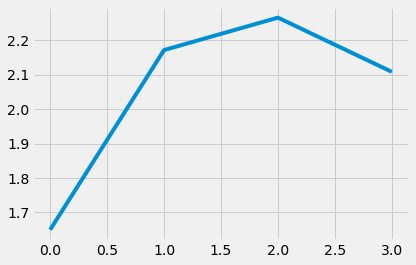

In [96]:
plt.plot(model_training.history['val_loss'])

In [83]:
model

In [ ]:
steps = [('scaler',StandardScaler()),
         ('elasticnet', ElasticNet())]


In [153]:
train = df['2011-7':'2012-6']
test = df['2012-1':'2012-12']
X_train = train[nn_predictors]
y_train = train[['registered_log','casual_log']]
X_test = test[nn_predictors]
y_test = test[['registered_log','casual_log']]

In [154]:
scaler = StandardScaler()
#steps = [('scaler', StandardScaler())]
#pipeline = Pipeline(steps)
scaler.fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_train)
y_train =scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [155]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100),max_iter=500)
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [156]:
df['pred_nn'] = pd.DataFrame(scaler.inverse_transform(mlp.predict(X_test)),index = test.index).applymap(lambda x: np.exp(x) - 1).sum(axis=1).round()

In [157]:
df.loc['2012-1','pred_nn']

date
2012-01-01    2372.0
2012-01-02    2059.0
2012-01-03    2314.0
2012-01-04    2496.0
2012-01-05    3619.0
2012-01-06    4215.0
2012-01-07    4520.0
2012-01-08    3377.0
2012-01-09    2449.0
2012-01-10    3841.0
2012-01-11    2227.0
2012-01-12    3445.0
2012-01-13    3274.0
2012-01-14    2574.0
2012-01-15    2381.0
2012-01-16    2215.0
2012-01-17    2945.0
2012-01-18    3203.0
2012-01-19    3172.0
2012-01-20    3040.0
2012-01-21    1306.0
2012-01-22    1968.0
2012-01-23    2315.0
2012-01-24    4351.0
2012-01-25    3941.0
2012-01-26    3789.0
2012-01-27    3470.0
2012-01-28    3836.0
2012-01-29    3245.0
2012-01-30    3560.0
2012-01-31    4471.0
Name: pred_nn, dtype: float64

## Testing
这里不太清楚是分别test还是ensemble后的模型

For model testing, the data sets from '2012-1-1' to '2012-6-30' were used. The data was splitted to training and testing 

# Business	Performance

In [22]:
#2011 as training set
train = df['2011']
test = df['2012']
df.loc['2012','pred_cnt_with_2011'] = pred()

In [23]:
#default
df['pred_cnt_default'] = df['cnt'].shift(freq = pd.DateOffset(days= 2))

##  Profit for 2012
Our model had a total profit 1734647 for the year of 2012.  The default prediction had a total profit 1442972 for the year of 2012

In [24]:
rentals = pd.Series([3,8,2.2],index = [3,8,2.2])

In [25]:
def profit(rental,pred,target = 'cnt', period = '2012'):
    return (rental*df.loc[period, [target,pred]].min(axis=1)-2*df.loc[period, pred]).sum()

In [26]:
def profit_ratio(rental,pred, target = 'cnt', period = '2012'):
    return (rental*df.loc[period, [target,pred]].min(axis=1)-2*df.loc[period, pred]).sum()/(2*df.loc[period, pred].sum())

In [158]:
#profit
preds = ['cnt', 'pred_cnt_rolling_1year','pred_cnt_rolling_all', 'pred_cnt_with_2011','pred_cnt_default', 'pred_nn']
profit_table = pd.concat([rentals.apply(profit, pred = pred).rename(f"profit by {pred.replace('pred_cnt_', '')}") for pred in preds], axis=1)
profit_table

,profit by cnt,profit by rolling_1year,profit by rolling_all,profit by with_2011,profit by default,profit by pred_nn
3.0,2049576.0,1740398.0,1759249.0,1126706.0,1442972.0,1602420.0
8.0,12297456.0,11160778.0,11219254.0,6811626.0,10683042.0,11369670.0
2.2,409915.2,233137.2,245648.2,217118.8,-35439.2,39660.0


In [159]:
#div by perfect pridiction
profit_table.div(profit_table['profit by cnt'], axis=0)

,profit by cnt,profit by rolling_1year,profit by rolling_all,profit by with_2011,profit by default,profit by pred_nn
3.0,1.0,0.849150,0.858348,0.549726,0.704034,0.781830
8.0,1.0,0.907568,0.912323,0.553905,0.868720,0.924555
2.2,1.0,0.568745,0.599266,0.529668,-0.086455,0.096752


## Profit expressed as a percentage of total expenditure
Our model has the profit/cost ratio of 0.4436 for the year of 2012. The default prediction has the profit/cost ratio of 0.3519 for the year of 2012

In [29]:
#profit ratio
profit_ratio_table = pd.concat([rentals.apply(profit_ratio, pred = pred).rename(f"profit_ratio by {pred[-3:]}") for pred in preds], axis=1)
profit_ratio_table

,profit_ratio by cnt,profit_ratio by ear,profit_ratio by all,profit_ratio by 011,profit_ratio by ult
3.0,0.5,0.444906,0.449160,0.493251,0.351853
8.0,3.0,2.853084,2.864427,2.982002,2.604940
2.2,0.1,0.059598,0.062717,0.095051,-0.008641


## Performance with rental variation
Our prediction model is always better than the default model. 

## Performance with season or other variation
model performance correlated with season, month and working days

In [30]:
def profit_perfect_ratio(df, pred,rental,target = 'cnt'):
    return (rental*df.loc[:, [target ,pred]].min(axis=1)-2*df.loc[:, pred]).sum()/((rental-2)*df.loc[:, pred].sum())

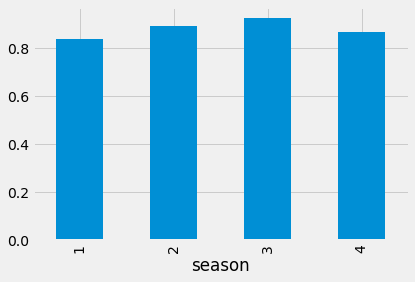

In [31]:
df.loc['2012',['season','cnt','pred_cnt_rolling_1year']].groupby('season').apply(
    profit_perfect_ratio,pred = 'pred_cnt_rolling_1year',rental = 3).plot('bar')

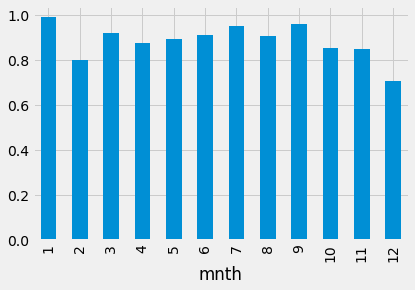

In [32]:
df.loc['2012',['mnth','cnt','pred_cnt_rolling_1year']].groupby('mnth').apply(
    profit_perfect_ratio,pred = 'pred_cnt_rolling_1year',rental = 3).plot(kind = 'bar')

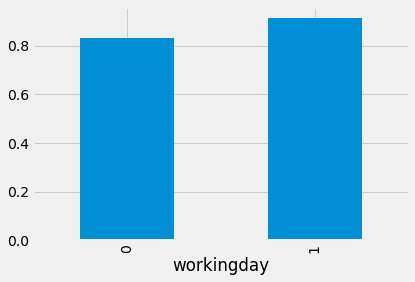

In [33]:
df.loc['2012',['workingday','cnt','pred_cnt_rolling_1year']].groupby('workingday').apply(
    profit_perfect_ratio,pred = 'pred_cnt_rolling_1year',rental = 3).plot(kind = 'bar')

## Performance with age variation
Our model performance did not decreases with the age of the model. 年底的可能是圣诞新年长假影响。10月份的应该是Hurricane Sandy。

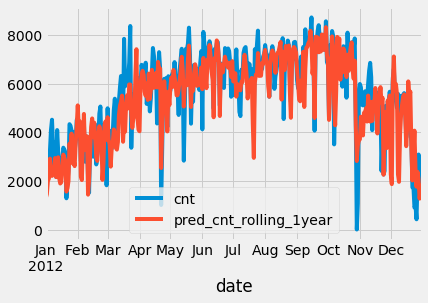

In [34]:
#by day
df.loc['2012',['cnt','pred_cnt_rolling_1year']].plot()

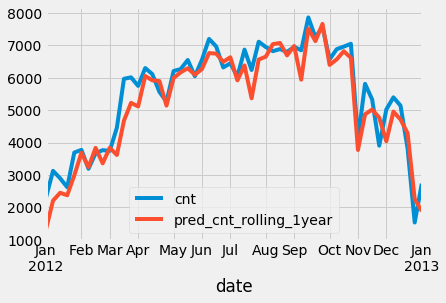

In [36]:
#absolute by week
df.loc['2012',['cnt','pred_cnt_rolling_1year']].resample('W').mean().plot()

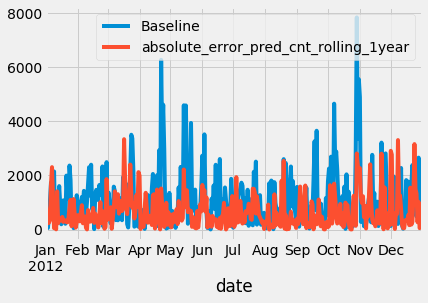

In [37]:
#absolute error by day
absolute_error = pd.DataFrame({'Baseline':(df.loc['2012','pred_cnt_default'] - df.loc['2012','cnt']).abs(), 'absolute_error_pred_cnt_rolling_1year':
                               (df.loc['2012','pred_cnt_rolling_1year'] - df.loc['2012','cnt']).abs()})
absolute_error.plot()

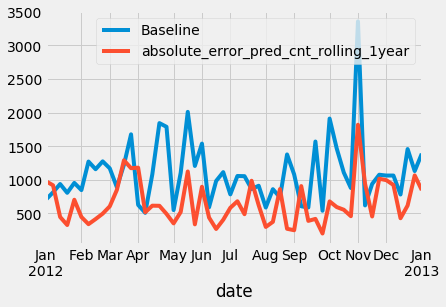

In [38]:
#error by week
absolute_error.resample('W').mean().plot()

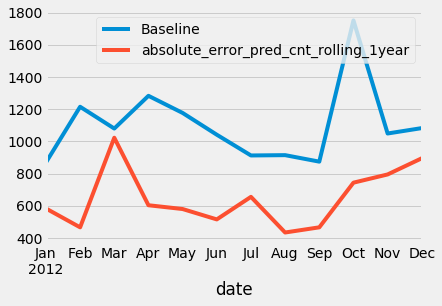

In [39]:
#error by month
absolute_error.resample('M').mean().plot()

## Performance with train set variation
The model generated from the 18month training set (Jan’11 to Jun’12) give higher profit than the model built from the 12month training set when tested on the test period Jul’12 to Dec’12(910857.0.0, 881944.0.0). Although the difference is relative quite small.

In [40]:
#train with 18m (2011-1 - 2012-6)
train = df['2011-1':'2012-6']
test = df['2012-7':'2012-12']
df.loc['2012-7':'2012-12','pred_cnt_with_18m'] = pred()

In [41]:
#train with 12m (2011-7-1 - 2012-6-30)
train = df['2011-7':'2012-6']
test = df['2012-7':'2012-12']
df.loc['2012-7':'2012-12','pred_cnt_with_12m'] = pred()

In [53]:
preds_train_variations = ['pred_cnt_with_18m','pred_cnt_with_12m']
profit_table_train_variation = pd.concat([rentals.apply(profit, pred = pred).rename(f"Profit by {pred.replace('pred_cnt_','')}") for pred in preds], axis=1)
profit_table_train_variation

,Profit by cnt,Profit by rolling_1year,Profit by rolling_all,Profit by with_2011,Profit by default
3.0,2049576.0,1740398.0,1759249.0,1126706.0,1442972.0
8.0,12297456.0,11160778.0,11219254.0,6811626.0,10683042.0
2.2,409915.2,233137.2,245648.2,217118.8,-35439.2


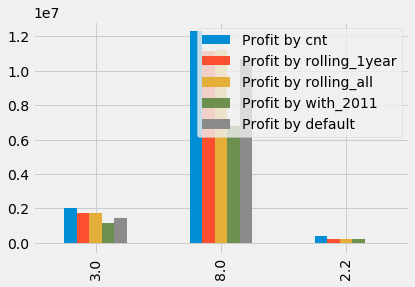

In [56]:
profit_table_train_variation.plot(kind = 'bar')

## Performance with balancing data
After balancing the data, the evidence that gave higher performance could not be seen (balanced:896724 vs unblanced 910857.0	, There might be minor changes for balanced data due to ramdomizations).

In [46]:
#train with 18m (2011-1 - 2012-6) wtih down sampling
n=20
pred_cnt_with_18m_wtih_down_sampling = np.zeros(n)
for i in range(n):
    train = pd.concat([pd.concat([df['2011-1':'2011-6'],df['2012-1':'2012-6']]).sample(
        frac=(365-184)/363),df['2011-7':'2011-12']])
    test = df['2012-7':'2012-12']
    df.loc['2012-7':'2012-12','pred_cnt_with_18m_wtih_down_sampling'] = pred()
    pred_cnt_with_18m_wtih_down_sampling[i] = profit(
        pred ='pred_cnt_with_18m_wtih_down_sampling', rental = 3,period = slice('2012-7','2012-12'))

In [47]:
pred_cnt_with_18m_wtih_down_sampling

array([ 906593.,  880539.,  898514.,  903510.,  896384.,  902657.,
        911432.,  909046.,  923429.,  905184.,  885395.,  908445.,
        900809.,  900731.,  884027.,  898909.,  918111.,  897030.,
        884896.,  886886.])

In [48]:
profit_with_18m_in_6m_with_sample_down = pred_cnt_with_18m_wtih_down_sampling.mean()
profit_with_18m_in_6m_with_sample_down

900126.34999999998

In [58]:
profit_with_18m_in_6m_table = profit_table_train_variation.loc[3,:].append(
    pd.Series(profit_with_18m_in_6m_with_sample_down, index = ['profit_with_18m_in_6m_with_sample_down']))

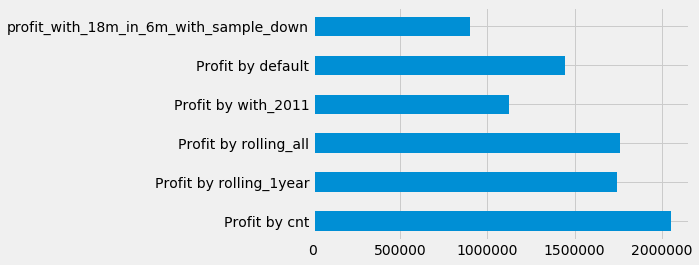

In [59]:
profit_with_18m_in_6m_table.plot(kind = 'barh')